In [13]:
#run first 


from tensorflow.keras.applications import MobileNet
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf

def get_encoder(input_shape, l2_regularization=0.01):
    """ Returns the image encoding model using MobileNet """
    pretrained_model = MobileNet(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for layer in pretrained_model.layers[:-27]:
        layer.trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    
    return encode_model

1/1 [==============================] - 0s 38ms/step


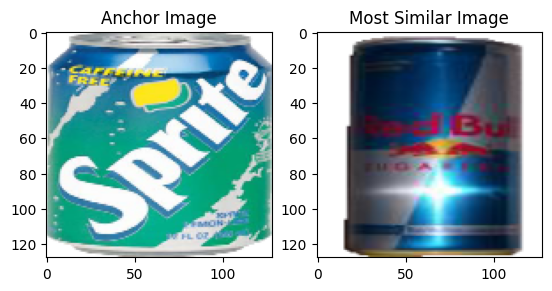

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


# Assuming you have the `get_encoder` and `SiameseModel` functions defined
# from your previous code

root_folder = "D:/semester 7/New folder"

# Load the saved encoder
def load_encoder(input_shape=(128, 128, 3)):
    encoder = get_encoder(input_shape)
    encoder.load_weights("encoder")
    return encoder

# Function to load test images
def load_test_images(folder_name):
    images = []
    file_indices= len(os.listdir(os.path.join(folder_name)))

    for index in range(1,file_indices):
        filename = f"product{index}.png"
        path = os.path.join(root_folder, folder_name, filename)
        
        try:
            image = cv2.imread(path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (128, 128))
                images.append(image)
            else:
                print(f"Unable to read image: {path}")
        except Exception as e:
            print(f"Error reading image {path}: {e}")
    
    return np.array(images)


# Load the saved encoder
encoder = load_encoder()

# Load the anchor image
anchor_image_path = os.path.join(root_folder, "Anchor.png")
anchor_image = cv2.imread(anchor_image_path)
anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
anchor_image = cv2.resize(anchor_image, (128, 128))

# Load the unseen images
unseen_images_case2 = load_test_images(root_folder)  # Replace with your unseen image indices

def compare_reference_to_unseen(encoder, reference_image, unseen_images):
    reference_image = np.expand_dims(reference_image, axis=0)  # Add batch dimension
    reference_encoding = encoder.predict(reference_image)

    predictions = []

    for unseen_image in unseen_images:
        unseen_image = np.expand_dims(unseen_image, axis=0)
        unseen_encoding = encoder.predict(unseen_image)

        # Compute the distance between the reference and unseen encodings
        distance = np.sum(np.square(reference_encoding - unseen_encoding))
        predictions.append(distance)

    # Find the index of the image with the minimum distance
    most_similar_index = np.argmin(predictions)

    return most_similar_index


# Compare the reference image to unseen images
most_similar_index = compare_reference_to_unseen(encoder, anchor_image, unseen_images_case2)

# Display the reference and most similar images
plt.subplot(1, 2, 1)
plt.imshow(anchor_image)
plt.title("Anchor Image")

plt.subplot(1, 2, 2)
plt.imshow(unseen_images_case2[most_similar_index])
plt.title("Most Similar Image")

plt.show()
